# LUNG CANCER DETECTION

## Datasets

### Kaggle

Kaggle provided CT scan images from 1397 patients for the training set and 198 patients used for the test set 
There are over 250,000 gray-scale images of size 512 × 512. 

The main difficulty faced when using this dataset, aside from its large size, is that the labels provided are at the patient-level only; in other words, no information is provided about the location and classification of nodules.


### Luna16

The dataset contains 888 CT scans of size 512 × 512 with nodules location

## help function

### import

In [1]:
import SimpleITK as sitk
import numpy as np
import csv
from glob import glob
import pandas as pd
import os

import pydicom

import scipy.ndimage
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

import matplotlib.pyplot as plt

from skimage import morphology
from skimage import measure
from sklearn.cluster import KMeans
from skimage.transform import resize

try:
    from tqdm import tqdm 
except:
    tqdm = lambda x: x

In [3]:
def load_itk(filename, reverse=True):
    itkimage = sitk.ReadImage(filename)
    ct_scan = sitk.GetArrayFromImage(itkimage)  # z,y,x
    
    ct_scan[ct_scan < -2000] = 0
    
    if reverse == True:
        origin = np.array(list(reversed(itkimage.GetOrigin())))   # z,y,x
        spacing = np.array(list(reversed(itkimage.GetSpacing()))) # z,y,x
        
    else:
        origin = itkimage.GetOrigin()   # x,y,z
        spacing = itkimage.GetSpacing() # x,y,z

    return ct_scan, origin, spacing

In [5]:
# Getting list of image files
path = "D:/Lung cancer/"
SUBSETS_path = path + "SUBSETS/"
subset_path = path + "SUBSETS/subset0/"
segmentation_path = path + 'seg-lungs-LUNA16/'
csv_path = path + 'csv/'

output_path = path + 'output/'
working_path = path + 'working/'

slices_path = path + 'SLICES/'

file_list = glob(subset_path + "*.mhd")

segmentation_list = glob(segmentation_path + "*.mhd")

In [9]:
# list of nodules
annotations = pd.read_csv(path + "csv/annotations.csv")

# list of patients
df_all = pd.read_csv(path + 'csv/candidates_V2.csv')

# 888 patients with labels
df_label = df_all.groupby('seriesuid').agg({'class': np.max}).reset_index()
df_label['class'].value_counts()

1    600
0    288
Name: class, dtype: int64

In [7]:
# subset 0
subset0 = [file.replace('.mhd', '') for file in os.listdir(subset_path) if 'mhd' in file]
s0_df = pd.read_csv(path + 'csv/candidates_V2.csv')
s0_df.seriesuid = s0_df.seriesuid.apply(lambda x: x if x in subset0 else None)
s0_df = s0_df.dropna()

In [8]:
s0_label = s0_df.groupby('seriesuid').agg({'class': np.max}).reset_index()
s0_label['class'].value_counts()

1    67
0    22
Name: class, dtype: int64

In [11]:
class0 = s0_label[s0_label['class'] == 0]
class1 = s0_label[s0_label['class'] == 1]

# seriesuid
s0_0 = [uid for uid in subset0 if uid in class0.seriesuid.values]
s0_1 = [uid for uid in subset0 if uid in class1.seriesuid.values]

### plot

In [15]:
def plot_2D_image(img_file):
    if type(img_file) == str:
        img = load_itk(img_file)[0]
    else:
        img = img_file
        
    plt.figure(figsize=(15, len(img_file)/25*3.5))
    j = 0
    for i in range(0, len(img), 5):
        subs = int(np.ceil(len(img) / 25) )
        plt.subplot(subs, 5, j+1)
        j += 1
        plt.imshow(img[i], cmap=plt.cm.bone)
    plt.show()

In [16]:
def plot_3D_image(image_file, threshold=-300):
    
    # Position the scan upright, 
    # so the head of the patient would be at the top facing the camera
    
    if type(image_file) == str:
        image = load_itk(image_file)[0]
    else:
        image = image_file
    
    p = image.transpose(2,1,0)
    
    verts, faces, x, y = measure.marching_cubes_lewiner(p, threshold)

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Fancy indexing: `verts[faces]` to generate a collection of triangles
    mesh = Poly3DCollection(verts[faces], alpha=0.70)
    face_color = [0.45, 0.45, 0.75]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)

    ax.set_xlim(0, p.shape[0])
    ax.set_ylim(0, p.shape[1])
    ax.set_zlim(0, p.shape[2])

    plt.show()

## Exploration

<img src="framework.gif">

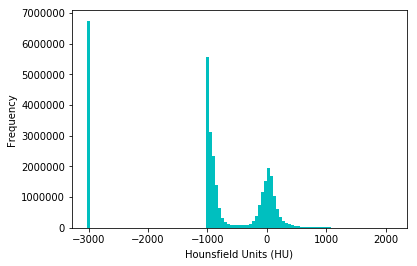

In [13]:
# Some scanners have cylindrical scanning bounds, but the output image is square. 
#The pixels that fall outside of these bounds get the fixed value -2000. 
#The first step is setting these values to 0, which currently corresponds to air. 
#Next, let's go back to HU units, by multiplying with the rescale slope and adding 
#the intercept (which are conveniently stored in the metadata of the scans!
img = sitk.GetArrayFromImage(sitk.ReadImage(file_list[0]))

plt.hist(img.flatten(), bins=100, color='c')
plt.xlabel("Hounsfield Units (HU)")
plt.ylabel("Frequency")
plt.show()

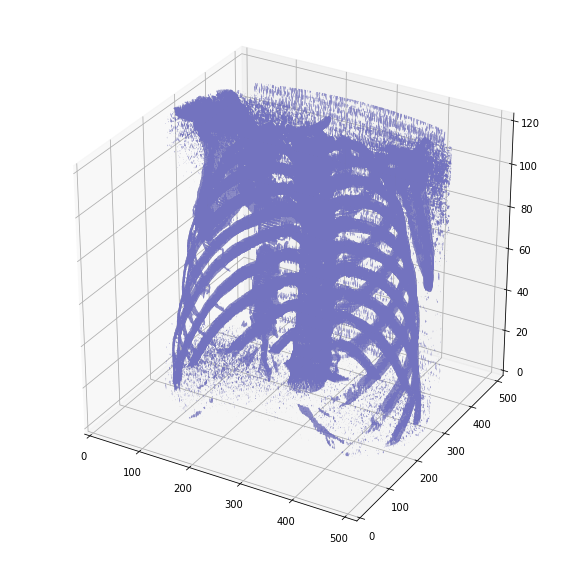

In [17]:
# 3D visualization threshold = 400 (bone)
plot_3D_image(file_list[0], 400) 

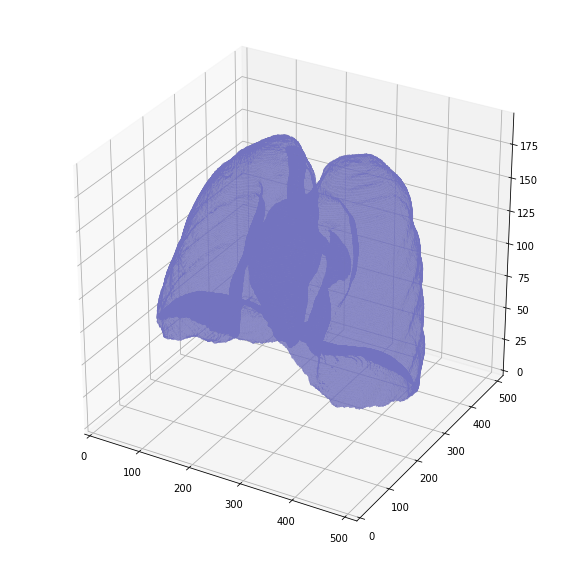

In [18]:
# 3D visualization threshold = 0 (lung)
plot_3D_image(segmentation_list[0], 0) 

In [27]:
## same as range(start, stop, step)
def seq(start, stop, step=1):
    n = int(round((stop - start)/float(step)))
    if n > 1:
        return([start + step*i for i in range(n+1)])
    else:
        return([])

def world_2_voxel(world, origin, spacing):
    voxel = np.absolute(world - origin) / spacing 
    return voxel

def voxel_2_world(voxel, origin, spacing):
    world = voxel * spacing + origin
    return world

In [28]:
# create spherical regions in binary masks at the given locations and radius
def draw_circles(image_array, df, origin, spacing):
    #make empty matrix, which will be filled with the mask
    RESIZE_SPACING = [1, 1, 1]
    image_mask = np.zeros(image_array.shape)
    
    #run over all the nodules in the lungs
        #get middel x-,y-, and z-worldcoordinate of the nodule
    for mini_df in df.values:   
        radius = np.ceil(mini_df[4])/2
        coord_x = mini_df[1]
        coord_y = mini_df[2]
        coord_z = mini_df[3]
        image_coord = np.array((coord_z,coord_y,coord_x))

        #determine voxel coordinate given the worldcoordinate
        image_coord = world_2_voxel(image_coord,origin,spacing)

        #determine the range of the nodule
        noduleRange = seq(-radius, radius, RESIZE_SPACING[0])

        #create the mask
        for x in noduleRange:
            for y in noduleRange:
                for z in noduleRange:
                    coords = world_2_voxel(np.array((coord_z + z, coord_y + y,coord_x + x)),origin,spacing)

                    if (np.linalg.norm(image_coord-coords) * RESIZE_SPACING[0]) < radius:
                        image_mask[int(np.round(coords[0])),int(np.round(coords[1])),
                                   int(np.round(coords[2]))] = int(1)

    return image_mask

In [38]:
def plot_nodules(image_path, df, RESIZE_SPACING=[1,1,1]):    
    img, origin, spacing = load_itk(image_path)
    #mask, _, _ = load_itk(mask_path)

    #determine the cads in a lung from csv file
    imageName = os.path.split(image_path)[1].replace('.mhd','')
    image_cads = df[df['seriesuid'] == imageName]

    #calculate resize factor
    new_shape = np.round(img.shape * (spacing/RESIZE_SPACING))
    real_resize = new_shape / img.shape
    new_spacing = spacing / real_resize

    #resize image & resize lung-mask
    lung_img = scipy.ndimage.interpolation.zoom(img, real_resize)
    #lung_mask = scipy.ndimage.interpolation.zoom(mask, real_resize)

    #lung_mask to 0-1
    #lung_mask[lung_mask > 0] = 1

    #create nodule mask
    nodule_mask = draw_circles(lung_img, image_cads, origin,new_spacing)

    plot_3D_image(nodule_mask, 0)

In [30]:
def createImageList(subset, df):
    subset_path = f'D:/Lung cancer/SUBSETS/subset{subset}'
    image_paths = glob(f'{subset_path}/*.mhd')
    
    images_with_nodules = []
    for image_path in image_paths:
        name = os.path.split(image_path)[1].replace('.mhd','')
        if len(df[df['seriesuid'] == name].index.tolist()) != 0: 
            images_with_nodules.append(image_path)    
    return images_with_nodules

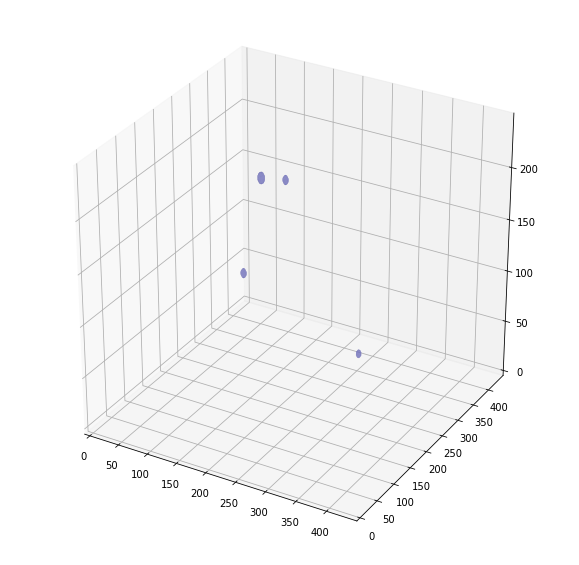

In [39]:
subset = 0
image_paths = createImageList(subset, annotations)
image_path = image_paths[8]

plot_nodules(image_path, annotations)

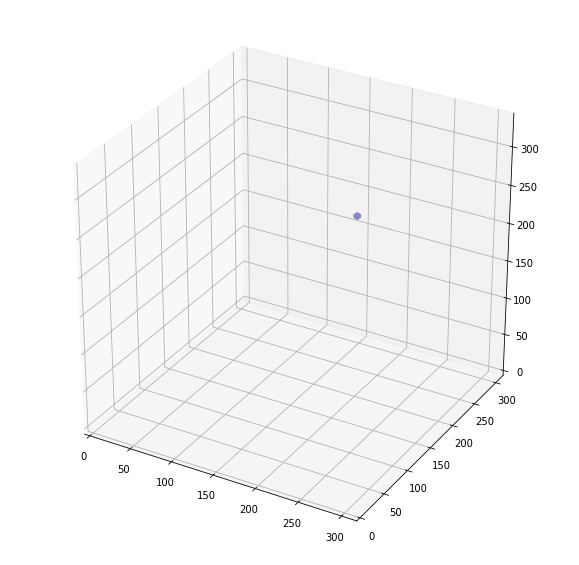

In [42]:
def create_slices(image_path, mask_path, df, RESIZE_SPACING=[1,1,1]):    
    img, origin, spacing = load_itk(image_path)
    mask, _, _ = load_itk(mask_path)

    #determine the cads in a lung from csv file
    imageName = os.path.split(image_path)[1].replace('.mhd','')
    image_cads = df[df['seriesuid'] == imageName]

    #calculate resize factor
    new_shape = np.round(img.shape * (spacing/RESIZE_SPACING))
    real_resize = new_shape / img.shape
    new_spacing = spacing / real_resize

    #resize image & resize lung-mask
    lung_img = scipy.ndimage.interpolation.zoom(img, real_resize)
    lung_mask = scipy.ndimage.interpolation.zoom(mask, real_resize)

    #lung_mask to 0-1
    lung_mask[lung_mask > 0] = 1

    #create nodule mask
    nodule_mask = draw_circles(lung_img, image_cads, origin,new_spacing)

    # Determine which slices contain nodules
    sliceList = []
    for z in range(nodule_mask.shape[0]):
        if np.sum(nodule_mask[z,:,:]) > 0:
            sliceList.append(z)

    lung_512, lung_mask_512, nodule_mask_512 = [], [], []       
    #save slices
    for z in sliceList:
        #padding to 512x512
        original_shape = lung_img.shape
        lung_slice_512 = np.zeros((512,512)) - 3000
        lung_mask_slice_512 = np.zeros((512,512))
        nodule_mask_slice_512 = np.zeros((512,512))

        offset = (512 - original_shape[1])
        upper_offset = int(np.round(offset/2))
        lower_offset = offset - upper_offset

        new_origin = voxel_2_world([-upper_offset,-lower_offset,0], origin, new_spacing)

        lung_slice_512[upper_offset:-lower_offset,upper_offset:-lower_offset] = lung_img[z,:,:]
        lung_mask_slice_512[upper_offset:-lower_offset,upper_offset:-lower_offset] = lung_mask[z,:,:]
        nodule_mask_slice_512[upper_offset:-lower_offset,upper_offset:-lower_offset] = nodule_mask[z,:,:]

        lung_512.append(lung_slice_512) 
        lung_mask_512.append(lung_mask_slice_512) 
        nodule_mask_512.append(nodule_mask_slice_512) 
    
    lung_512 = np.asarray(lung_512)
    lung_mask_512 = np.asarray(lung_mask_512)
    nodule_mask_512 = np.asarray(nodule_mask_512)
    
    return lung_512, lung_mask_512, nodule_mask_512

In [43]:
subset = 0
image_paths = createImageList(subset, annotations)
image_path = image_paths[8]
mask_path = image_path.replace(f'SUBSETS/subset{subset}', 'seg-lungs-LUNA16')

lung, lung_mask, nodule_mask = create_slices(image_path, mask_path, annotations)

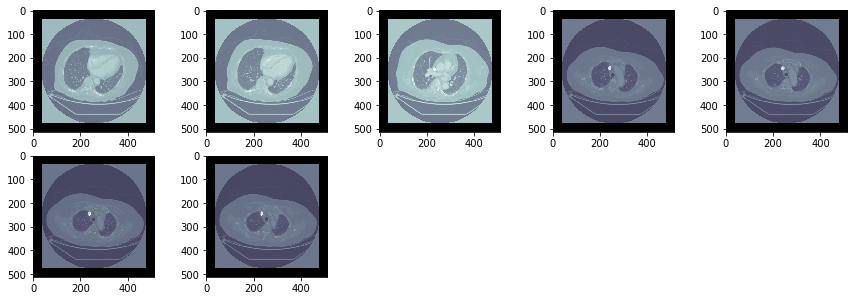

In [46]:
plot_2D_image(lung)

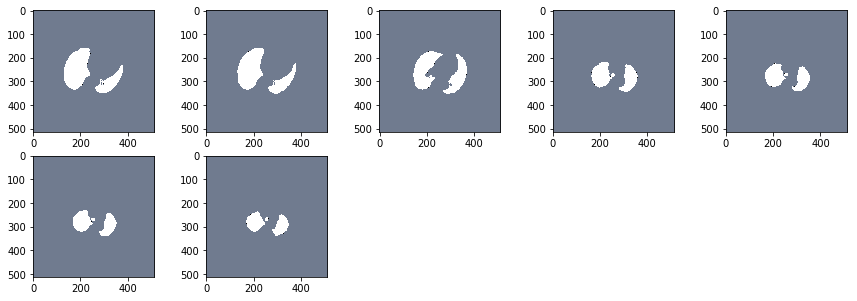

In [47]:
plot_2D_image(lung_mask)

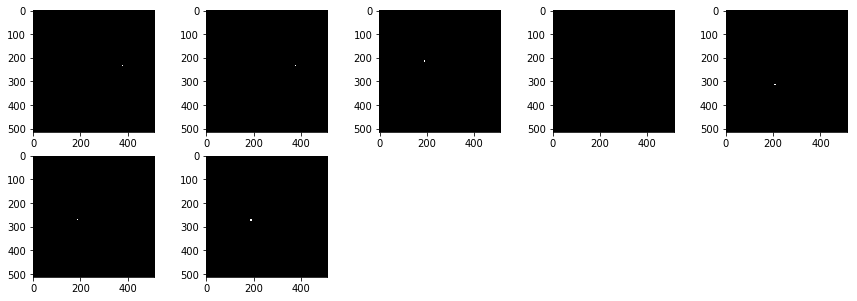

In [48]:
plot_2D_image(nodule_mask)

## Preprocess 

In [67]:
from __future__ import division

import numpy as np
from skimage import measure
from sklearn.cluster import KMeans
from skimage.transform import resize
from skimage import morphology
from skimage.draw import circle
from skimage import measure
from skimage.transform import resize

In [58]:
def get_filename(file_list, case):
    for f in file_list:
        if case in f:
            return(f)

In [60]:
# The locations of the nodules in subsuet0
df_annotations = pd.read_csv(path + "csv/annotations.csv")
df_annotations["file"] = df_annotations["seriesuid"].map(lambda file_name: get_filename(file_list, file_name))
df_annotations = df_annotations.dropna()
df_annotations

,seriesuid,coordX,coordY,coordZ,diameter_mm,file
23,1.3.6.1.4.1.14519.5.2.1.6279.6001.108197895896...,-100.567944,67.260517,-231.816619,6.440879,D:/Lung cancer/SUBSETS/subset0\1.3.6.1.4.1.145...
25,1.3.6.1.4.1.14519.5.2.1.6279.6001.109002525524...,46.188539,48.402806,-108.578632,13.596471,D:/Lung cancer/SUBSETS/subset0\1.3.6.1.4.1.145...
26,1.3.6.1.4.1.14519.5.2.1.6279.6001.109002525524...,36.392044,76.771663,-123.321911,4.343200,D:/Lung cancer/SUBSETS/subset0\1.3.6.1.4.1.145...
28,1.3.6.1.4.1.14519.5.2.1.6279.6001.111172165674...,136.434059,117.765579,-181.947817,4.681382,D:/Lung cancer/SUBSETS/subset0\1.3.6.1.4.1.145...
86,1.3.6.1.4.1.14519.5.2.1.6279.6001.124154461048...,145.967465,-161.197634,-312.071347,6.378436,D:/Lung cancer/SUBSETS/subset0\1.3.6.1.4.1.145...
...,...,...,...,...,...,...
1125,1.3.6.1.4.1.14519.5.2.1.6279.6001.868211851413...,-22.951826,78.571156,-136.901025,6.430802,D:/Lung cancer/SUBSETS/subset0\1.3.6.1.4.1.145...
1137,1.3.6.1.4.1.14519.5.2.1.6279.6001.898642529028...,-42.200674,92.207156,-566.589551,4.678130,D:/Lung cancer/SUBSETS/subset0\1.3.6.1.4.1.145...
1138,1.3.6.1.4.1.14519.5.2.1.6279.6001.898642529028...,74.399625,112.651026,-534.715881,4.581767,D:/Lung cancer/SUBSETS/subset0\1.3.6.1.4.1.145...
1141,1.3.6.1.4.1.14519.5.2.1.6279.6001.905371958588...,109.116637,48.589511,-120.892058,21.583112,D:/Lung cancer/SUBSETS/subset0\1.3.6.1.4.1.145...


In [75]:
def segment_lungs(img, nodule_mask=None):
    mean = np.mean(img)
    std = np.std(img)
    img = (img - mean) / std
    img = img.astype(np.float64)
    middle = img[100:400, 100:400]
    mean = np.mean(middle)
    img_max = np.max(img)
    img_min = np.min(img)

    img[img == img_max] = mean
    img[img == img_min] = mean

    kmeans = KMeans(n_clusters=2).fit(np.reshape(middle, [np.prod(middle.shape), 1]))
    centers = sorted(kmeans.cluster_centers_.flatten())
    threshold = np.mean(centers)
    thresh_img = np.where(img < threshold, 1.0, 0.0)

    eroded = morphology.erosion(thresh_img, np.ones([4, 4]))
    dilation = morphology.dilation(eroded, np.ones([10, 10]))

    labels = measure.label(dilation)
    regions = measure.regionprops(labels)
    good_labels = []
    for prop in regions:
        B = prop.bbox
        if B[2] - B[0] < 475 and B[3] - B[1] < 475 and B[0] > 40 and B[2] < 472:
            good_labels.append(prop.label)
    mask = np.ndarray([512, 512], dtype=np.int8)
    mask[:] = 0

    for N in good_labels:
        mask += np.where(labels == N, 1, 0)

    mask = morphology.dilation(mask, np.ones([10, 10]))

    img = mask * img

    new_mean = np.mean(img[mask > 0])
    new_std = np.std(img[mask > 0])

    old_min = np.min(img)
    img[img == old_min] = new_mean - 1.2 * new_std
    img = (img - new_mean) / new_std

    labels = measure.label(mask)
    regions = measure.regionprops(labels)

    min_row = 512
    max_row = 0
    min_col = 512
    max_col = 0
    for prop in regions:
        B = prop.bbox
        if min_row > B[0]:
            min_row = B[0]
        if min_col > B[1]:
            min_col = B[1]
        if max_row < B[2]:
            max_row = B[2]
        if max_col < B[3]:
            max_col = B[3]
    width = max_col - min_col
    height = max_row - min_row
    if width > height:
        max_row = min_row + width
    else:
        max_col = min_col + height

    img = img[min_row:max_row, min_col:max_col]
    if max_row - min_row < 5 or max_col - min_col < 5:
        return ()
    else:
        mean = np.mean(img)
        img -= mean
        img_min = np.min(img)
        img_max = np.max(img)
        img /= (img_max - img_min)
        new_img = resize(img, [512, 512])
        if isinstance(nodule_mask, np.ndarray):
            nodule_mask = nodule_mask.astype(np.float64)
            new_nodule_mask = resize(nodule_mask[min_row:max_row, min_col:max_col], [512, 512])
        else:
            new_nodule_mask = 0

        return new_img, new_nodule_mask

In [63]:
"""Function that returns a list of tuples identifying the nodule locations
       in a file, where each tuple is (x-coord, y-coord, z-coord, diameter). If
       biggest=True, returns only biggest nodule in file.
    """

def get_nodules(img_file, df, biggest=False):
    mini_df = df[df['file'] == img_file]
    if len(mini_df) == 0:
        return []

    if biggest:
        idx = np.argsort(mini_df['diameter_mm'].values)[-1:]
    else:
        idx = range(len(mini_df))

    x = mini_df['coordX'].values[idx]
    y = mini_df['coordY'].values[idx]
    z = mini_df['coordZ'].values[idx]
    diam = mini_df['diameter_mm'].values[idx]
    return list(zip(x, y, z, diam))

In [51]:
def get_arrays(img_file, df, biggest=False):
    """Function that returns 3 lists (masks, large_masks, imgs), where each list is
       is a list of numpy arrays. The len of each list is equal to the number of
       nodules in img_file (or 1 if biggest=True); i.e., only one slice is added per
       nodule. The shape of the arrays is 512x512. Two versions of masks are returned:
       masks, which identify nodules by circles of twice the diameter of the ground
       truth; and large_masks, with circles of 4x the ground truth diameter.
    """  
    nodules = get_nodules(img_file, df,  biggest=False)

    img, origin, spacing = load_itk(img_file, reverse=False)

    masks = []
    #large_masks = []
    imgs = []
    for nodule in nodules:
        #word -> voxel
        center = np.array(nodule[:3])  # xyz
        v_center = np.rint((center-origin)/spacing).astype(int)  # xyz
        v_diam = int(np.round(nodule[3]/spacing[0]))

        mask = np.zeros((img.shape[1], img.shape[2]), dtype=np.int8)  # yx
        rr, cc = circle(v_center[1], v_center[0], 2*(v_diam/2), shape=mask.shape)
        mask[rr, cc] = 1
        masks.append(mask)

#         mask = np.zeros((img.shape[1], img.shape[2]), dtype=np.int8)  # yx
#         rr, cc = circle(v_center[1], v_center[0], 4*(v_diam/2), shape=mask.shape)
#         mask[rr, cc] = 1
#         large_masks.append(mask)
        imgs.append(img[v_center[2], :, :])

    masks = np.asarray(masks)
    #large_masks = np.asarray(large_masks)
    imgs = np.asarray(imgs)
    
    return masks, imgs

In [64]:
def all(all_files, df):
    imgs = np.zeros((2000, 512, 512), dtype=np.float32)
    masks = np.zeros((2000, 512, 512), dtype=np.float32)
    #large_masks = np.zeros((2000, 512, 512), dtype=np.int8)
    i, count1 = 0, 0
    #for img_file in tqdm(all_files):
    for img_file in all_files:
        print(img_file)
        arrays = get_arrays(img_file, df)
        if len(arrays[0]) == 0:
            continue
        nb = len(arrays[0])
        masks[i:i+nb, :, :] = arrays[0]
        #large_masks[i:i+nb, :, :] = arrays[1]
        imgs[i:i+nb, :, :] = arrays[1]
        i += nb
        
        count1 += 1
        print(count1, end=' ')
        

    imgs = imgs[:i, :, :]
    masks = masks[:i, :, :]
    #large_masks = large_masks[:i, :, :]

    # a few masks have nodule locations outside the 512x512 region for some reason.
    # removing these
    #large_masks_new = np.zeros(large_masks.shape)
    masks_new = np.zeros(masks.shape)
    imgs_new = np.zeros(imgs.shape)
    count = 0
    for idx, img in enumerate(imgs):
        if np.sum(masks[idx]) == 0:
            continue
        imgs_new[count] = (img - np.mean(img))/np.std(img)
        masks_new[count] = masks[idx]
        #large_masks_new[count] = large_masks[idx]
        count += 1

    imgs = imgs_new[:count]
    masks = masks_new[:count]
    #large_masks = large_masks_new[:count]
    
    return imgs, masks

In [68]:
imgs, masks = all(file_list, df_annotations)

D:/Lung cancer/SUBSETS/subset0\1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031515062000744821260.mhd
D:/Lung cancer/SUBSETS/subset0\1.3.6.1.4.1.14519.5.2.1.6279.6001.108197895896446896160048741492.mhd
1 D:/Lung cancer/SUBSETS/subset0\1.3.6.1.4.1.14519.5.2.1.6279.6001.109002525524522225658609808059.mhd
2 D:/Lung cancer/SUBSETS/subset0\1.3.6.1.4.1.14519.5.2.1.6279.6001.111172165674661221381920536987.mhd
3 D:/Lung cancer/SUBSETS/subset0\1.3.6.1.4.1.14519.5.2.1.6279.6001.122763913896761494371822656720.mhd
D:/Lung cancer/SUBSETS/subset0\1.3.6.1.4.1.14519.5.2.1.6279.6001.124154461048929153767743874565.mhd
4 D:/Lung cancer/SUBSETS/subset0\1.3.6.1.4.1.14519.5.2.1.6279.6001.126121460017257137098781143514.mhd
D:/Lung cancer/SUBSETS/subset0\1.3.6.1.4.1.14519.5.2.1.6279.6001.126264578931778258890371755354.mhd
5 D:/Lung cancer/SUBSETS/subset0\1.3.6.1.4.1.14519.5.2.1.6279.6001.128023902651233986592378348912.mhd
6 D:/Lung cancer/SUBSETS/subset0\1.3.6.1.4.1.14519.5.2.1.6279.6001.12905597763733863974169

59 D:/Lung cancer/SUBSETS/subset0\1.3.6.1.4.1.14519.5.2.1.6279.6001.752756872840730509471096155114.mhd
60 D:/Lung cancer/SUBSETS/subset0\1.3.6.1.4.1.14519.5.2.1.6279.6001.805925269324902055566754756843.mhd
61 D:/Lung cancer/SUBSETS/subset0\1.3.6.1.4.1.14519.5.2.1.6279.6001.826812708000318290301835871780.mhd
62 D:/Lung cancer/SUBSETS/subset0\1.3.6.1.4.1.14519.5.2.1.6279.6001.832260670372728970918746541371.mhd
63 D:/Lung cancer/SUBSETS/subset0\1.3.6.1.4.1.14519.5.2.1.6279.6001.868211851413924881662621747734.mhd
64 D:/Lung cancer/SUBSETS/subset0\1.3.6.1.4.1.14519.5.2.1.6279.6001.898642529028521482602829374444.mhd
65 D:/Lung cancer/SUBSETS/subset0\1.3.6.1.4.1.14519.5.2.1.6279.6001.905371958588660410240398317235.mhd
66 D:/Lung cancer/SUBSETS/subset0\1.3.6.1.4.1.14519.5.2.1.6279.6001.975254950136384517744116790879.mhd
D:/Lung cancer/SUBSETS/subset0\1.3.6.1.4.1.14519.5.2.1.6279.6001.979083010707182900091062408058.mhd
67 

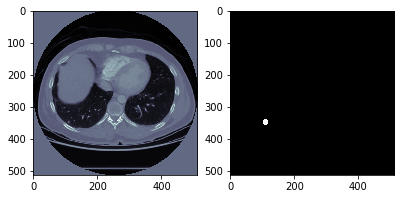

In [80]:
plt.figure(figsize=(10,10))
plt.subplot(1,3,1)
plt.imshow(imgs[0], cmap=plt.cm.bone)

plt.subplot(1,3,2)
plt.imshow(masks[0], cmap=plt.cm.bone)

plt.subplot(1,3,2)
plt.imshow(masks[0], cmap=plt.cm.bone)

## UNET to predict masks

In [69]:
from keras.models import Model, Sequential
from keras.layers import Input, Conv3D, BatchNormalization, Convolution2D, MaxPooling2D, Dropout, concatenate, Conv2D, Conv2DTranspose
from keras.layers import MaxPool3D, Flatten, Dense

from keras.optimizers import Adam
from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as K

In [94]:
smooth = 1.

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_np(y_true,y_pred):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (np.sum(y_true_f) + np.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(images, label, test_size=0.2, random_state=42)

In [70]:
K.set_image_data_format('channels_first')

In [71]:
def get_unet(lr):
    inputs = Input((1, 512, 512))
    conv1 = Convolution2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Convolution2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Convolution2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Convolution2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Convolution2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Convolution2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Convolution2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Convolution2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Convolution2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Convolution2D(512, (3, 3), activation='relu', padding='same')(conv5)
    
    up_sampling2D = UpSampling2D(size=(2,2))
    up6 = concatenate([UpSampling2D(size=(2, 2))(conv5), conv4], axis=1)
    conv6 = Convolution2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Convolution2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([UpSampling2D(size=(2, 2))(conv6), conv3], axis=1)
    conv7 = Convolution2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Convolution2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([UpSampling2D(size=(2, 2))(conv7), conv2], axis=1)
    conv8 = Convolution2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Convolution2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([UpSampling2D(size=(2, 2))(conv8), conv1], axis=1)
    conv9 = Convolution2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Convolution2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Convolution2D(1, (1, 1), activation='sigmoid')(conv9)

    model = Model(inputs=inputs, outputs=conv10)

    model.compile(optimizer=Adam(lr=lr), loss=dice_coef_loss, metrics=[dice_coef])

    return model

In [85]:
model = get_unet(1e-4)
    # Saving weights to unet.hdf5 at checkpoints
model_checkpoint = ModelCheckpoint('unet.hdf5', monitor='loss', save_best_only=True)
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.8 ** x)
from keras.callbacks import CSVLogger

csv_logger = CSVLogger('segmentation.log', separator=',', append=False)

In [ ]:
model.fit(img_train, mask_train, batch_size=4, epochs=10, verbose=1,
              callbacks=[model_checkpoint, csv_logger])

Epoch 1/20
708/708 [==============================] - 133s 188ms/step - loss: 0.9889 - dice_coef: 0.0111

Epoch 2/20
708/708 [==============================] - 130s 183ms/step - loss: 0.9886 - dice_coef: 0.0114

Epoch 3/20
708/708 [==============================] - 129s 182ms/step - loss: 0.9886 - dice_coef: 0.0114

Epoch 4/20
708/708 [==============================] - 129s 183ms/step - loss: 0.9866 - dice_coef: 0.0134

Epoch 5/20
708/708 [==============================] - 129s 183ms/step - loss: 0.9877 - dice_coef: 0.0123

Epoch 6/20
708/708 [==============================] - 129s 183ms/step - loss: 0.9888 - dice_coef: 0.0112
Epoch 7/20
708/708 [==============================] - 129s 183ms/step - loss: 0.9875 - dice_coef: 0.0125
Epoch 8/20
708/708 [==============================] - 128s 181ms/step - loss: 0.9887 - dice_coef: 0.0113
Epoch 9/20
708/708 [==============================] - 128s 181ms/step - loss: 0.9882 - dice_coef: 0.0118
Epoch 10/20
708/708 [==============================] - 129s 182ms/step - loss: 0.9885 - dice_coef: 0.0115
Epoch 11/20
708/708 [==============================] - 128s 181ms/step - loss: 0.9854 - dice_coef: 0.0146
Epoch 12/20
708/708 [==============================] - 128s 181ms/step - loss: 0.9882 - dice_coef: 0.0118
Epoch 13/20
708/708 [==============================] - 128s 181ms/step - loss: 0.9893 - dice_coef: 0.0107
Epoch 14/20
708/708 [==============================] - 128s 181ms/step - loss: 0.9869 - dice_coef: 0.0131
Epoch 15/20
708/708 [==============================] - 128s 180ms/step - loss: 0.9877 - dice_coef: 0.0123
Epoch 16/20
708/708 [==============================] - 128s 181ms/step - loss: 0.9876 - dice_coef: 0.0124
Epoch 17/20
708/708 [==============================] - 129s 182ms/step - loss: 0.9876 - dice_coef: 0.0124

Epoch 18/20
708/708 [==============================] - 129s 182ms/step - loss: 0.9879 - dice_coef: 0.0121

Epoch 19/20
708/708 [==============================] - 129s 182ms/step - loss: 0.9884 - dice_coef: 0.0116

Epoch 20/20
708/708 [==============================] - 128s 181ms/step - loss: 0.9878 - dice_coef: 0.0122

## 3D CNN without unet

In [89]:
import keras
from keras.models import Model, Sequential
from keras.layers import Input, Conv3D, BatchNormalization, Convolution2D, MaxPooling2D, Dropout, concatenate, Conv2D, Conv2DTranspose
from keras.layers import MaxPool3D, Flatten, Dense

from keras.optimizers import Adam
from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as K

In [95]:
def reduce_slicing(img, num_scice=90):
    if type(img) == str:
        image = load_itk(img)[0]
    else:
        image = img
    
    cut = image.shape[0] // 2
    new_image = image[cut-int(num_scice/2) : cut+int(num_scice/2), :,:]
  
    return new_image

In [96]:
def resize(lung_mask, nodule_mask):
    num = lung_mask.shape[0]
    final_lung = np.ndarray([num, 1, 512, 512], dtype=np.float16)
    final_nodule = np.ndarray([num, 1, 512, 512], dtype=np.float16)
    
    for i in tqdm(range(num)):
        final_lung[i,0] = lung_mask[i]
        final_nodule[i,0] = nodule_mask[i]
        
    return final_lung, final_nodule

In [97]:
label = s0_label['class'].values
label = keras.utils.to_categorical(label)

In [90]:
input_shape = (1,20,512,512)
model = Sequential([
    Conv3D(filters=8, kernel_size=(3,3,3), input_shape=input_shape, activation='relu'),
    MaxPool3D(pool_size=(1,2,2)),
    Dropout(0.25),

    Conv3D(filters=32, kernel_size=(3,3,3), input_shape=input_shape, activation='relu'),
    MaxPool3D(pool_size=(1,2,2)),
    Dropout(0.25),

    Conv3D(filters=64, kernel_size=(3,3,3), input_shape=input_shape, activation='relu'),
    MaxPool3D(pool_size=(1,2,2)),
    Dropout(0.25),

    Conv3D(filters=128, kernel_size=(3,3,3), input_shape=input_shape, activation='relu'),
    MaxPool3D(pool_size=(1,2,2)),
    Dropout(0.25),

    Conv3D(filters=256, kernel_size=(3,3,3), input_shape=input_shape, activation='relu'),
    MaxPool3D(pool_size=(1,2,2)),
    Dropout(0.25),

    Conv3D(filters=512, kernel_size=(3,3,3), input_shape=input_shape, activation='relu'),
    MaxPool3D(pool_size=(1,2,2)),
    Dropout(0.25),

    Flatten(),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(2, activation='sigmoid')
])

model.compile(loss=keras.losses.binary_crossentropy,
              optimizer=keras.optimizers.Adam(0.0001),
              metrics=['accuracy'])